# _Moneyballing Fantasy Premier League Football_
# Deep Learning

So far, our traditional 'shallow' learning algorithms have really struggled to predict effectively.

We should, of course, be managing our expectations somewhat. There are goals scored in the Premier League that just could not have been predicted. Just last week, a central defender for Norwich, the bottom-placed team, decided to have a punt from a very difficult angle against one of the league's best defences. It was a peach of a goal - but there's just no way any predictive model could have seen it coming.

![title](Images/Lewis.gif)

## Why might Neural Networks do better?

Recall the structure of our data - for a single row, we actually have several 'sets' of inputs. There are three types of player attacking data (featuring different matches, as appropriate), as well as two sets of opponent team data (again, featuring different sets of matches).

Thus, multple layers can deal with the combinations of these data groups separately (in theory at least).

For example, the first layer might calculate the aggregate attacking capability of the player, and the aggregate defensive capability of the other team. The next layer could work out how susceptible the defence is to that type of player (e.g. if they're the type of defence that concedes a lot of headers, which the attacking player tends to get a lot of). The final layer would then be the output of whether a player scores or not.

Of course, in reality it is quite unlikely that a network would behave in such a way, but we can give it a go!

## Bring on the libraries

... and the data...

In [1]:
#Standard data manipulations
import pandas as pd
import numpy as np

#Data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#For NN work
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# required_features = ['LastMinutes', 'LastRelativeStrength', 'LastGoals', 'LastShotsOnTarget',
#        'LastShotsInBox', 'LastCloseShots', 'LastTotalShots', 'LastShotsCentre',
#        'LastShotsLeft', 'LastShotsRight', 'LastShotOnTargetCreated',
#        'LastShotInBoxCreated', 'LastCloseShotCreated', 'LastTotalShotCreated',
#        'LastCreatedCentre', 'LastCreatedLeft', 'LastCreatedRight',
#        'Last4Minutes', 'Last4RelativeStrength', 'Last4Goals',
#        'Last4ShotsOnTarget', 'Last4ShotsInBox', 'Last4CloseShots',
#        'Last4TotalShots', 'Last4ShotsCentre', 'Last4ShotsLeft',
#        'Last4ShotsRight', 'Last4ShotOnTargetCreated', 'Last4ShotInBoxCreated',
#        'Last4CloseShotCreated', 'Last4TotalShotCreated', 'Last4CreatedCentre',
#        'Last4CreatedLeft', 'Last4CreatedRight', 'Last4HAMinutes',
#        'Last4HARelativeStrength', 'Last4HAGoals', 'Last4HAShotsOnTarget',
#        'Last4HAShotsInBox', 'Last4HACloseShots', 'Last4HATotalShots',
#        'Last4HAShotsCentre', 'Last4HAShotsLeft', 'Last4HAShotsRight',
#        'Last4HAShotOnTargetCreated', 'Last4HAShotInBoxCreated',
#        'Last4HACloseShotCreated', 'Last4HATotalShotCreated',
#        'Last4HACreatedCentre', 'Last4HACreatedLeft', 'Last4HACreatedRight',
#        'OppLast4RelativeStrength', 'OppLast4Possession',
#        'OppLast4GoalsConceded', 'OppLast4ShotsConceded', 'OppLast4ShotsInBoxConceded',
#        'OppLast4CloseShotsConceded', 'OppLast4HeadersConceded',
#        'OppLast4ShotsCentreConceded', 'OppLast4ShotsLeftConceded',
#        'OppLast4ShotsRightConceded', 'OppLast4HARelativeStrength',
#        'OppLast4HAPossession', 'OppLast4HAGoalsConceded',
#        'OppLast4HAShotsConceded', 'OppLast4HAShotsInBoxConceded',
#        'OppLast4HACloseShotsConceded', 'OppLast4HAHeadersConceded',
#        'OppLast4HAShotsCentreConceded', 'OppLast4HAShotsLeftConceded',
#        'OppLast4HAShotsRightConceded']

In [3]:
features = pd.read_csv('Data/Datasets/df_features_p.csv', index_col='Unnamed: 0')
y = pd.read_csv('Data/Datasets/df_targets_p.csv', index_col='Unnamed: 0')

XG = y['XG']
XA = y['XA']
XGI = y['XGI']

#Create test/train splits as required
X_train_XG, X_test_XG, y_train_XG, y_test_XG = train_test_split(features,XG,
                                                                random_state=50,
                                                                test_size=0.2)

X_train_XA, X_test_XA, y_train_XA, y_test_XA = train_test_split(features,XG,
                                                                random_state=50,
                                                                test_size=0.2)

X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI = train_test_split(features,
                                                                    XG,random_state=50,
                                                                    test_size=0.2)


#Get the player/match IDs for the train test split
index = pd.read_csv('Data/Datasets/df_index_p.csv', index_col='Unnamed: 0')
index = index['Player'] + ' ' + index['MatchID'].astype(str)

X_train, X_test, index_train, index_test = train_test_split(features, index, random_state=50, test_size=0.2)

#We will need to scale our data for the neural networks
XG_scaler = StandardScaler()
XG_scaled = XG_scaler.fit_transform(X_train_XG)

XA_scaler = StandardScaler()
XA_scaled = XA_scaler.fit_transform(X_train_XA)

XGI_scaler = StandardScaler()
XGI_scaled = XGI_scaler.fit_transform(X_train_XGI)

print(features.shape)

(4493, 83)


Let's also create some functions that we'll use to measure the networks' effectiveness.

In [4]:
def adj_r2(y_true, y_pred, n_feat=len(features.columns)):
    '''
    Takes true ys, predicted ys, the number of samples,
    and the number of variables.
    Calculates adjusted r squared
    '''
    n_samp = len(y_true)
    
    #Calculate regular r2
    R2 = r2_score(y_true, y_pred)
    
    #Return adjusted rsquared
    return 1-(1-R2)*(n_samp-1)/(n_samp-n_feat-1)



def plot_model(y_true, y_pred, title=None, size=(6,6)):
    '''
    Plots y_true against y_pred
    '''
    #Plot the scatter
    plt.figure(figsize=size)
    plt.scatter(y_pred, y_true, s=10, alpha=0.5)
    
    #Plot x=y
    max_val = max([y_true.max(), y_pred.max()])
    plt.plot([0,max_val],[0,max_val],color='red',lw=1,ls='--')

    plt.xlim(0)
    plt.ylim(0)

    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title(title);
    


def visualize_training_results(results, size=(5,3)):
    #Get the 'history' of the training results
    history = results.history
    
    #Plot the mse
    plt.figure(figsize=size)
    plt.plot(history['val_mse'], lw=3)
    plt.plot(history['mse'], lw=3)
    plt.legend(['val_mse', 'mse'], frameon=False)
    plt.title('MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.xlim(0)
    
    #Plot the rmse
    plt.figure(figsize=size)
    plt.plot(np.array(history['val_mse'])**0.5, lw=3)
    plt.plot(np.array(history['mse'])**0.5, lw=3)
    plt.legend(['val_mse', 'rmse'], frameon=False)
    plt.title('RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.xlim(0);
    
    

def performance(model, scaler, X_train, X_test,
                y_train, y_test, size=(5,3)):
    
    '''
    Takes a model, a scaler, and a train test split dataset.
    '''
    
    #Scale our data as required
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #Get predictions from the model
    y_hat_train = model.predict(X_train_scaled)
    y_hat_test = model.predict(X_test_scaled)
    
    print('\n_________R2_________\n')
    print('Train R2:', round(r2_score(y_train, y_hat_train),4))
    print('Test R2:', round(r2_score(y_test, y_hat_test),4))
    print('\nTrain Adj R2:', round(adj_r2(y_train, y_hat_train),4))
    print('Test Adj R2:', round(adj_r2(y_test, y_hat_test),4))
    
    print('\n_________MSE________\n')
    print('Train MSE:', round(mean_squared_error(y_train, y_hat_train),4))
    print('Test MSE:', round(mean_squared_error(y_test, y_hat_test),4))
    print('\nTrain RMSE:', round(mean_squared_error(y_train, y_hat_train)**0.5,4))
    print('Test RMSE:', round(mean_squared_error(y_test, y_hat_test)**0.5,4))

    plot_model(y_train, y_hat_train, title='Training Set', size=size)
    
    plot_model(y_test, y_hat_test, title='Test Set', size=size)

## Building our first neural network

Let's contruct a basic neural network. This is going to be 'vanilla' with minimal hyperparameter work.

Let's start with two layers (the first of which will need 83 inputs).

Train on 2875 samples, validate on 719 samples
Epoch 1/5
2875/2875 [==============================] - 4s 2ms/step - loss: 0.1164 - mse: 0.1164 - val_loss: 0.1002 - val_mse: 0.1002
Epoch 2/5
2875/2875 [==============================] - 0s 62us/step - loss: 0.0846 - mse: 0.0846 - val_loss: 0.0921 - val_mse: 0.0921
Epoch 3/5
2875/2875 [==============================] - 0s 69us/step - loss: 0.0763 - mse: 0.0763 - val_loss: 0.0929 - val_mse: 0.0929
Epoch 4/5
2875/2875 [==============================] - 0s 65us/step - loss: 0.0673 - mse: 0.0673 - val_loss: 0.0959 - val_mse: 0.0959
Epoch 5/5
2875/2875 [==============================] - 0s 72us/step - loss: 0.0641 - mse: 0.0641 - val_loss: 0.0919 - val_mse: 0.0919

_________R2_________

Train R2: 0.3978
Test R2: 0.0561

Train Adj R2: 0.3836
Test Adj R2: -0.04

_________MSE________

Train MSE: 0.0634
Test MSE: 0.0855

Train RMSE: 0.2519
Test RMSE: 0.2925


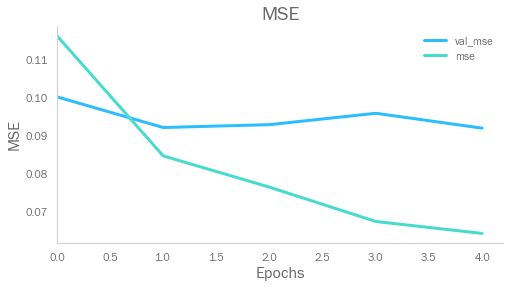

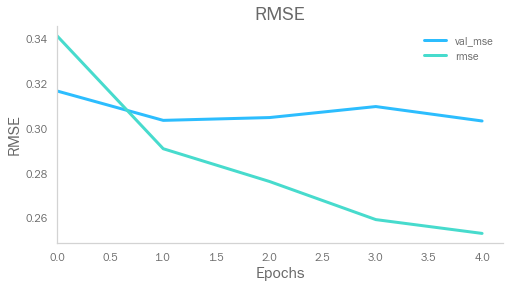

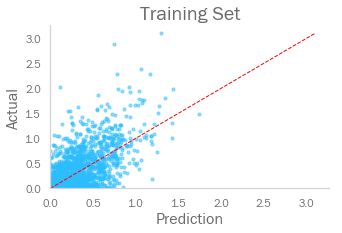

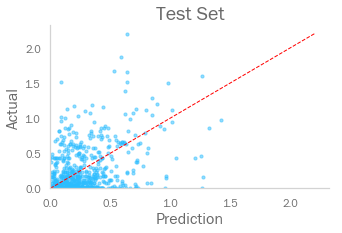

In [5]:
#Build out the first net
attnet_1 = Sequential()

#Let's start simple with a single layer
attnet_1.add(Dense(units=64, kernel_initializer='normal',
                   activation='relu', input_shape=(features.shape[1],)))
#And a final layer to give the final output...
attnet_1.add(Dense(1, activation="linear"))

#Compile the model
attnet_1.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['mse'])

#Fit the network...
att_res_1 = attnet_1.fit(XG_scaled, y_train_XG,
                         epochs=5, validation_split=0.2)

#Visualise the results
visualize_training_results(att_res_1, size=(8,4))

#Evaluate on the test set
performance(attnet_1, XG_scaler, X_train_XG, X_test_XG,
            y_train_XG, y_test_XG)

Suffice to say, this did not cover itself in glory.

It doesn't cope much better with the expected goal involvement metric.

Train on 3234 samples, validate on 360 samples
Epoch 1/15
3234/3234 [==============================] - 0s 132us/step - loss: 0.1160 - mse: 0.1160 - val_loss: 0.0977 - val_mse: 0.0977
Epoch 2/15
3234/3234 [==============================] - 0s 62us/step - loss: 0.0908 - mse: 0.0908 - val_loss: 0.0969 - val_mse: 0.0969
Epoch 3/15
3234/3234 [==============================] - 0s 62us/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.0888 - val_mse: 0.0888
Epoch 4/15
3234/3234 [==============================] - 0s 63us/step - loss: 0.0739 - mse: 0.0739 - val_loss: 0.0977 - val_mse: 0.0977
Epoch 5/15
3234/3234 [==============================] - 0s 58us/step - loss: 0.0711 - mse: 0.0711 - val_loss: 0.0928 - val_mse: 0.0928
Epoch 6/15
3234/3234 [==============================] - 0s 65us/step - loss: 0.0659 - mse: 0.0659 - val_loss: 0.0826 - val_mse: 0.0826
Epoch 7/15
3234/3234 [==============================] - 0s 70us/step - loss: 0.0671 - mse: 0.0671 - val_loss: 0.0859 - val_mse: 0.0859
Epoch 8

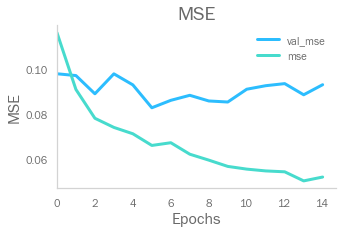

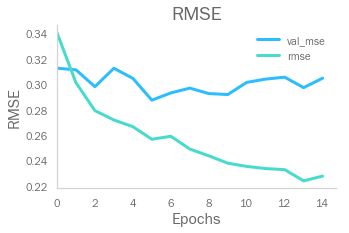

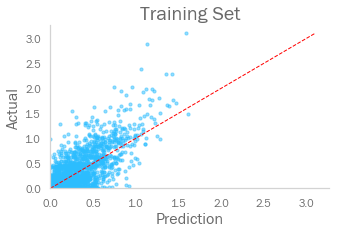

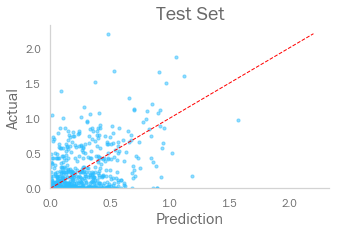

In [6]:
#Build out the net
attnet_2 = Sequential()

#Let's start simple with a single layer
attnet_2.add(Dense(units=64, kernel_initializer='normal',
                   activation='relu', input_shape=(features.shape[1],)))
#And a final layer to give the final output...
attnet_2.add(Dense(1, activation="linear"))

#Compile the model
attnet_2.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['mse'])

#Fit the network...
att_res_2 = attnet_2.fit(XGI_scaled, y_train_XGI,
                         epochs=15, validation_split=0.1)

#Visualise the results
visualize_training_results(att_res_2)

#Evaluate on the test set
performance(attnet_2, XGI_scaler, X_train_XGI, X_test_XGI,
            y_train_XGI, y_test_XGI)

Train on 2875 samples, validate on 719 samples
Epoch 1/10
2875/2875 [==============================] - 1s 229us/step - loss: 0.0896 - mse: 0.0896 - val_loss: 0.0810 - val_mse: 0.0810
Epoch 2/10
2875/2875 [==============================] - 0s 143us/step - loss: 0.0766 - mse: 0.0766 - val_loss: 0.0822 - val_mse: 0.0822
Epoch 3/10
2875/2875 [==============================] - 0s 119us/step - loss: 0.0713 - mse: 0.0713 - val_loss: 0.0859 - val_mse: 0.0859
Epoch 4/10
2875/2875 [==============================] - 0s 119us/step - loss: 0.0657 - mse: 0.0657 - val_loss: 0.0794 - val_mse: 0.0794
Epoch 5/10
2875/2875 [==============================] - 0s 127us/step - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0827 - val_mse: 0.0827
Epoch 6/10
2875/2875 [==============================] - 0s 119us/step - loss: 0.0486 - mse: 0.0486 - val_loss: 0.0859 - val_mse: 0.0859
Epoch 7/10
2875/2875 [==============================] - 0s 136us/step - loss: 0.0416 - mse: 0.0416 - val_loss: 0.0992 - val_mse: 0.0992
E

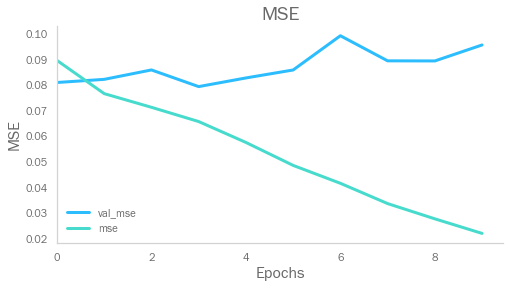

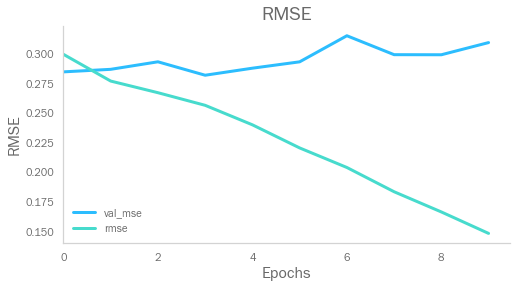

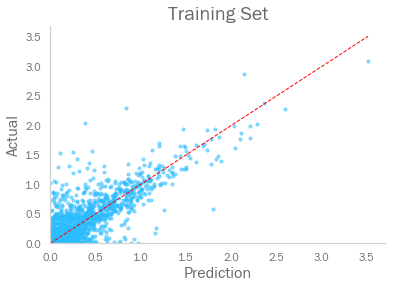

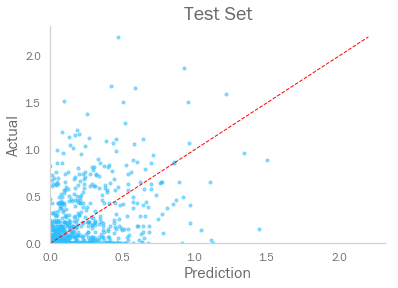

In [9]:
#Build out the first net
attnet_3 = Sequential()

#Let's start simple with a single layer
attnet_3.add(Dense(units=256, kernel_initializer='normal',
                   activation='relu', input_shape=(features.shape[1],)))
attnet_3.add(Dense(units=128, kernel_initializer='normal',
                   activation='relu'))
attnet_3.add(Dense(units=64, kernel_initializer='normal',
                   activation='relu'))
#And a final layer to give the final output...
attnet_3.add(Dense(1, activation="linear"))

#Compile the model
attnet_3.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['mse'])

#Fit the network...
att_res_3 = attnet_3.fit(XG_scaled, y_train_XG,
                         epochs=10, validation_split=0.2)

#Visualise the results
visualize_training_results(att_res_3, size=(8,4))

#Evaluate on the test set
performance(attnet_3, XG_scaler, X_train_XG, X_test_XG,
            y_train_XG, y_test_XG, size=(6,4))

Train on 2875 samples, validate on 719 samples
Epoch 1/15
2875/2875 [==============================] - 0s 139us/step - loss: 0.2164 - mse: 0.2164 - val_loss: 0.1195 - val_mse: 0.1195
Epoch 2/15
2875/2875 [==============================] - 0s 72us/step - loss: 0.1038 - mse: 0.1038 - val_loss: 0.0998 - val_mse: 0.0998
Epoch 3/15
2875/2875 [==============================] - 0s 65us/step - loss: 0.0835 - mse: 0.0835 - val_loss: 0.0956 - val_mse: 0.0956
Epoch 4/15
2875/2875 [==============================] - 0s 65us/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0941 - val_mse: 0.0941
Epoch 5/15
2875/2875 [==============================] - 0s 67us/step - loss: 0.0684 - mse: 0.0684 - val_loss: 0.0941 - val_mse: 0.0941
Epoch 6/15
2875/2875 [==============================] - 0s 69us/step - loss: 0.0637 - mse: 0.0637 - val_loss: 0.0933 - val_mse: 0.0933
Epoch 7/15
2875/2875 [==============================] - 0s 66us/step - loss: 0.0597 - mse: 0.0597 - val_loss: 0.0941 - val_mse: 0.0941
Epoch 8

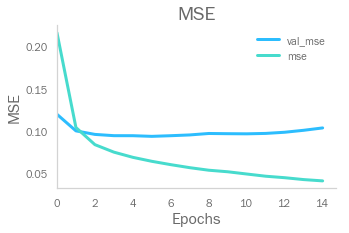

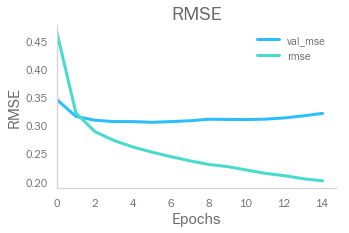

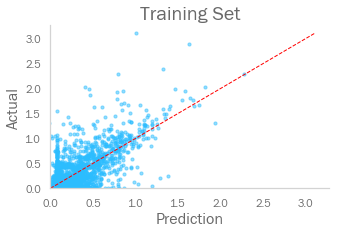

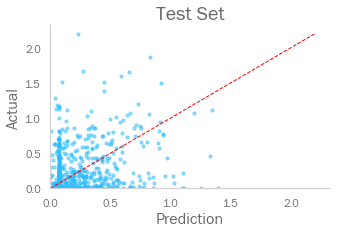

In [8]:
#Build out the first net
attnet_4 = Sequential()

#Let's start simple with a single layer
attnet_4.add(Dense(units=64, 
                   activation='relu', input_shape=(features.shape[1],)))
attnet_4.add(Dense(units=8,
                   activation='relu'))
#And a final layer to give the final output...
attnet_4.add(Dense(1, activation="linear"))

#Compile the model
attnet_4.compile(loss='mean_squared_error',
                 optimizer='adam',
                 metrics=['mse'])

#Fit the network...
att_res_4 = attnet_4.fit(XGI_scaled, y_train_XGI,
                         epochs=15, validation_split=0.2)

#Visualise the results
visualize_training_results(att_res_4)

#Evaluate on the test set
performance(attnet_4, XGI_scaler, X_train_XGI, X_test_XGI,
            y_train_XGI, y_test_XGI)